## 1) Import & Konfigurasi

In [1]:
import os, re, joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Konfigurasi
TRAIN_PATH = 'Data_latih.csv'
TEST_PATH  = 'Data_uji.csv'
TEXT_COLS = ['judul', 'narasi']
LABEL_COL = 'label'
USE_STEMMING = True
MAX_FEATURES = 10000
NGRAM = (1,2)

nltk.download('stopwords')
STOPWORDS_ID = set(stopwords.words('indonesian'))
print('Konfigurasi OK')


Konfigurasi OK


[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     ID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2) Muat & Gabungkan Teks

In [2]:
assert os.path.exists(TRAIN_PATH), f'Tidak menemukan {TRAIN_PATH}'
assert os.path.exists(TEST_PATH),  f'Tidak menemukan {TEST_PATH}'

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

def combine_text(df, cols):
    combo = pd.Series(['']*len(df))
    for c in cols:
        if c in df.columns:
            combo = (combo + ' ' + df[c].fillna('').astype(str)).str.strip()
    return combo

df_train['raw_text'] = combine_text(df_train, TEXT_COLS)
df_test['raw_text']  = combine_text(df_test, TEXT_COLS)

assert LABEL_COL in df_train.columns, f'Kolom {LABEL_COL} tidak ada di train'
display(df_train[[LABEL_COL,'raw_text']].head())
print('Distribusi label (train):')
print(df_train[LABEL_COL].value_counts())


,label,raw_text
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...
1,1,Instruksi Gubernur Jateng tentang penilangan ...
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b..."
4,1,Foto Kadrun kalo lihat foto ini panas dingin K...


Distribusi label (train):
label
1    3465
0     766
Name: count, dtype: int64


## 3) Preprocessing Bahasa Indonesia

In [3]:
stemmer = StemmerFactory().create_stemmer() if USE_STEMMING else None

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"@[\w_]+|#\w+", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    tokens = [w for w in s.split() if w not in STOPWORDS_ID and len(w) > 2]
    s = " ".join(tokens)
    if stemmer is not None:
        s = stemmer.stem(s)
    return s

df_train['clean_text'] = df_train['raw_text'].progress_apply(clean_text)
df_test['clean_text']  = df_test['raw_text'].progress_apply(clean_text)

display(df_train[['raw_text','clean_text']].head())


100%|██████████| 470/470 [01:45<00:00,  4.45it/s]


,raw_text,clean_text
0,Pemakaian Masker Menyebabkan Penyakit Legionna...,pakai masker sebab sakit legionnaires caller r...
1,Instruksi Gubernur Jateng tentang penilangan ...,instruksi gubernur jateng tilang masker muka 1...
2,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,foto jim rohn jokowi presiden baik dlm sejarah...
3,"ini bukan politik, tapi kenyataan Pak Jokowi b...",politik nyata jokowi hasil pulang 000 triliun ...
4,Foto Kadrun kalo lihat foto ini panas dingin K...,foto kadrun kalo lihat foto panas dingin kadru...


## 4) Split Train/Validation & TF–IDF

In [4]:
le = LabelEncoder()
y_all = le.fit_transform(df_train[LABEL_COL].astype(str))
X_all = df_train['clean_text']

X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM)
Xtr = tfidf.fit_transform(X_tr)
Xvl = tfidf.transform(X_val)
Xte = tfidf.transform(df_test['clean_text'])

print('Shapes ->', Xtr.shape, Xvl.shape, Xte.shape)


Shapes -> (3384, 10000) (847, 10000) (470, 10000)


## 5) Train & Evaluasi (Validation)

In [5]:
models = {
    'NaiveBayes': MultinomialNB(),
    'LogReg': LogisticRegression(max_iter=3000, class_weight='balanced'),
    'LinearSVM': LinearSVC(class_weight='balanced')
}

results = {}
for name, clf in models.items():
    clf.fit(Xtr, y_tr)
    pred_val = clf.predict(Xvl)
    acc = accuracy_score(y_val, pred_val)
    p, r, f1, _ = precision_recall_fscore_support(y_val, pred_val, average='weighted', zero_division=0)
    results[name] = {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}
    print(f'[{name}] acc={acc:.4f} | P={p:.4f} R={r:.4f} F1={f1:.4f}')
    print(classification_report(y_val, pred_val, digits=4))

best_name = max(results, key=lambda k: results[k]['f1'])
best_model = models[best_name]
print('Best model:', best_name, results[best_name])


[NaiveBayes] acc=0.8182 | P=0.6712 R=0.8182 F1=0.7374
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       153
           1     0.8191    0.9986    0.9000       694

    accuracy                         0.8182       847
   macro avg     0.4096    0.4993    0.4500       847
weighted avg     0.6712    0.8182    0.7374       847

[LogReg] acc=0.8099 | P=0.8065 R=0.8099 F1=0.8082
              precision    recall  f1-score   support

           0     0.4726    0.4510    0.4615       153
           1     0.8802    0.8890    0.8846       694

    accuracy                         0.8099       847
   macro avg     0.6764    0.6700    0.6731       847
weighted avg     0.8065    0.8099    0.8082       847

[LinearSVM] acc=0.8052 | P=0.7939 R=0.8052 F1=0.7989
              precision    recall  f1-score   support

           0     0.4538    0.3856    0.4170       153
           1     0.8689    0.8977    0.8831       694

    accuracy             

## 6) Confusion Matrix (Validation)

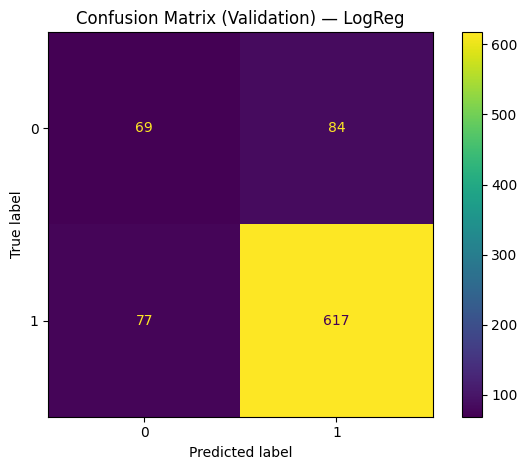

In [6]:
pred_val = best_model.predict(Xvl)
cm = confusion_matrix(y_val, pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Confusion Matrix (Validation) — {best_name}')
plt.tight_layout(); plt.show()


## 7) Wordcloud per Label (opsional)

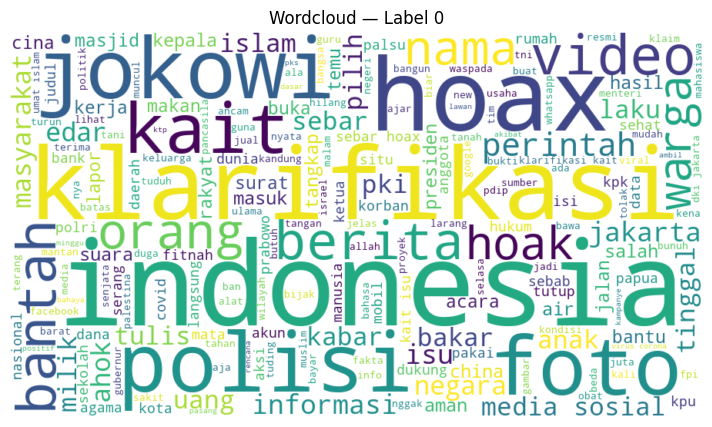

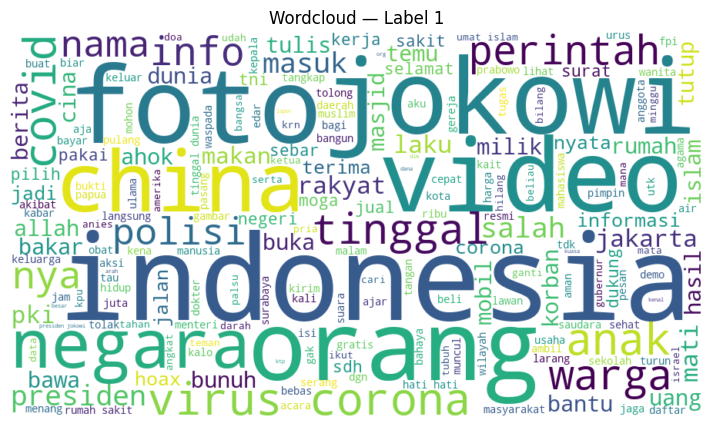

In [7]:
def plot_wordcloud(texts, title):
    wc = WordCloud(width=900, height=500, background_color='white').generate(" ".join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off'); plt.title(title); plt.show()

for lbl in le.classes_:
    subset = df_train[df_train[LABEL_COL].astype(str)==lbl]['clean_text']
    if len(subset)>0:
        plot_wordcloud(subset, f'Wordcloud — Label {lbl}')


## 8) Prediksi Data_uji & Simpan Artefak

In [8]:
import pandas as pd, os
os.makedirs('models', exist_ok=True)
joblib.dump(tfidf, f'models/tfidf_vectorizer.pkl')
joblib.dump(best_model, f'models/{best_name}_model.pkl')

pred_test_enc = best_model.predict(Xte)
pred_test_lbl = le.inverse_transform(pred_test_enc)

id_col = 'ID' if 'ID' in df_test.columns else None
out = pd.DataFrame({
    (id_col if id_col else 'row_id'): (df_test[id_col] if id_col else df_test.index),
    'pred_label': pred_test_lbl
})
out_path = 'prediksi_Data_uji.csv'
out.to_csv(out_path, index=False)

print('Artefak tersimpan: models/*.pkl &', out_path)


Artefak tersimpan: models/*.pkl & prediksi_Data_uji.csv


## 9) Ringkasan

In [9]:
import json
summary = {
    "best_model": best_name,
    "metrics_validation": results[best_name],
    "files": {
        "vectorizer": "models/tfidf_vectorizer.pkl",
        "model": f"models/{best_name}_model.pkl",
        "prediksi": "prediksi_Data_uji.csv"
    }
}
print(json.dumps(summary, indent=2))


{
  "best_model": "LogReg",
  "metrics_validation": {
    "accuracy": 0.8099173553719008,
    "precision": 0.8065490211215142,
    "recall": 0.8099173553719008,
    "f1": 0.8081692175533818
  },
  "files": {
    "vectorizer": "models/tfidf_vectorizer.pkl",
    "model": "models/LogReg_model.pkl",
    "prediksi": "prediksi_Data_uji.csv"
  }
}
